Import all important libraries

In [1]:
import numpy as np 
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, recall_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import SelectKBest, f_regression,mutual_info_regression
import xgboost as xgb
from sklearn.utils import resample
from sklearn.ensemble import VotingClassifier
import os
import itertools
from imblearn.over_sampling import SMOTE
import pickle

Import dataset created in the scraper notebook

In [33]:
df = pd.read_csv('Full_Shoe_Data_2019.csv',index_col=0)

Drop columns that dont provide value to future EDA and Modeling

In [34]:
df.drop(columns= ['urlKey', 'title', 'productCategory', 'contentGroup', 'primaryCategory', 'colorway', 'year','Shoe'], inplace=True)

Create a column that will allow us to explore the value of the season a sneaker is released.

In [35]:
df['releaseDate']= pd.to_datetime(df['releaseDate']) #Change the Release Date column to Datetime in order to manipulate in the future.

In [36]:
df["month"] = df['releaseDate'].map(lambda x: x.month) #Extract the month from the release date

In [37]:
month_dict= {12:1,1:1,2:1,3:2,4:2,5:2,6:3,7:3,8:3,9:4,10:4,11:4} #create a hashtable to provide the season a month is
df['Season']= df['month'].map(month_dict) #create a new column that provides the season a sneaker is released

Remove outliers

In [38]:
df= df[df['retailPrice']<=300]

In [39]:
df= df[df['Avg_Return']<=300]

## Statistical Analysis:

### ANOVA:

Hypothesis Testing:

Null: No statistical difference between Season Released and Average Profit

Alternative: There is a statisitcal difference between Season Released and Average Profit

In [40]:
stats.f_oneway(df['Avg_Profit'][df['Season'] == 1],
               df['Avg_Profit'][df['Season'] == 2],
               df['Avg_Profit'][df['Season'] == 3],
               df['Avg_Profit'][df['Season'] == 4])

F_onewayResult(statistic=1.0855357852124528, pvalue=0.354003405024968)

We CAN NOT reject the null hypothesis because our pvalue is Greater Than 0.05 (alpha set at .05).
Therefore we see there is no statistical difference between Season Released and Average Profit.

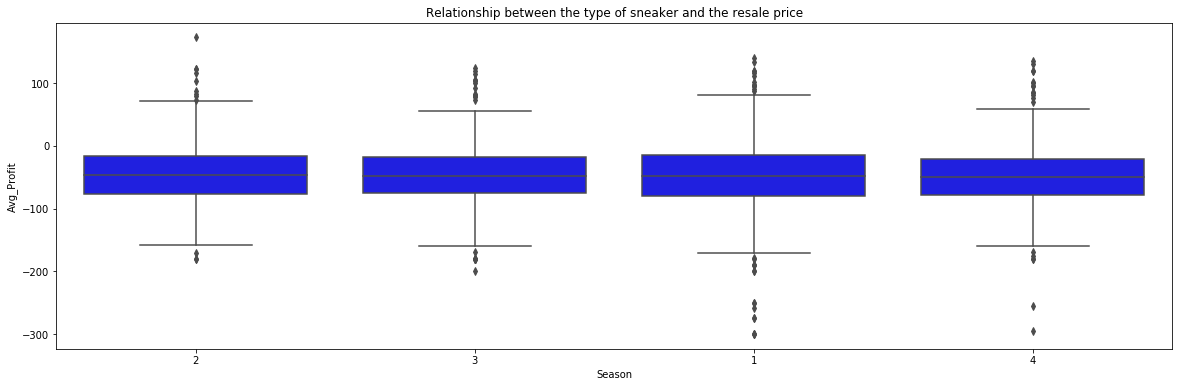

In [41]:
min_order = df.groupby('Season')['Avg_Profit'].median().sort_values(ascending = False).index
plt.figure(figsize=(20,6))
plt.title('Relationship between the type of sneaker and the resale price')
sns.boxplot(x='Season',y='Avg_Profit',data=df,color='b', order=min_order);

### ANOVA:

Hypothesis Testing:

Null: No statistical difference between Average Profit and Twitter Hype.


Alternative: There is a statisitcal difference between Average Profit and Twitter Hype.

In [42]:
stats.f_oneway(df['Avg_Profit'][df['twitter'] == 0],
               df['Avg_Profit'][df['twitter'] == 1])

F_onewayResult(statistic=13.498680697718392, pvalue=0.00024539666862206873)

We CAN reject the null hypothesis because our pvalue is Less Than 0.05 (alpha set at .05). Therefore we see there is a statistical difference between Average Profit and Twitter Hype.

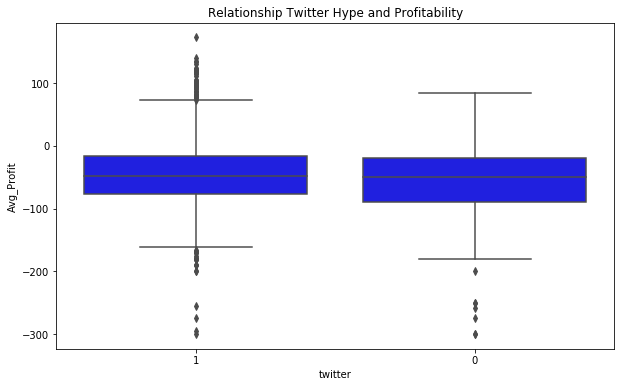

In [12]:
min_order = df.groupby('twitter')['Avg_Profit'].median().sort_values(ascending = False).index
plt.figure(figsize=(10,6))
plt.title('Relationship Twitter Hype and Profitability')
sns.boxplot(x='twitter',y='Avg_Profit',data=df,color='b', order=min_order);

### Two Sample T-Test:

Hypothesis Testing:

Null: No statistical difference between Average Profit for Nike Sneakers and Average Profit for Adidas Sneakers.

Alternative: There is a statisitcal difference between Average Number of Sales for Nike Sneakers and Average Number of Sales for Adidas Sneakers.

In [13]:
Nike_df = df[df['brand']=='Nike']
Adidas_df = df[df['brand']=='adidas']

In [14]:
stats.ttest_ind(Nike_df['Avg_Profit'],Adidas_df['Avg_Profit'], equal_var = False)

Ttest_indResult(statistic=5.42180187442611, pvalue=7.554731151667134e-08)

We CAN reject the null hypothesis because our pvalue is less than 0.05.

This tells us that there is a statisitcal difference between Average Number of Sales for Nike and Adidas Sneakers

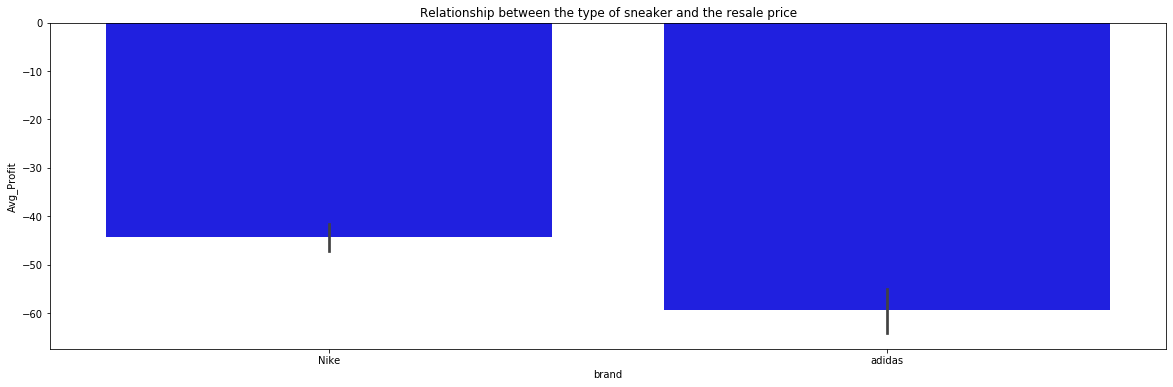

In [15]:
df_plot= df.groupby('brand')['Avg_Profit'].mean()
plt.figure(figsize=(20,6))
plt.title('Relationship between the type of sneaker and the resale price')
sns.barplot(x='brand',y='Avg_Profit',data=df,color='b');

# Categorical Modeling

Before getting started, its always nice to be able to visualize our confusion matrix so I wrote this function to be able to properly call it in the future.

In [16]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix',cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Based on our data we see that less than 25% of shoes that came out in 2019 were profitable and even less are worth the time it takes to acquire one of these shoes. Due to this we are going use a categorical model to predict if a shoe will resale at a high enough value to even consider buying (Profit > $50)

In [17]:
df_modeling=df

Create our target for the model

In [18]:
df_modeling['Target']= np.where(df_modeling['Avg_Profit']>=50, 1, 0)

In [19]:
df_modeling.drop(columns='Avg_Profit', inplace= True)

Remove columns unnecessary for modeling and create dummy variables for categorical variables.

In [20]:
df_modeling.drop(columns= ['Avg_Sale', 'Avg_Return', 'month','releaseDate','Best_Size', 'usHtsDescription','name'], inplace=True)
df_modeling= pd.get_dummies(data= df_modeling, columns= ['brand', 'secondaryCategory', 'shoe'])

### Standard Logistic Regression:

Is there a class imbalance?

In [18]:
df_modeling['Target'].value_counts()

0    1814
1      73
Name: Target, dtype: int64

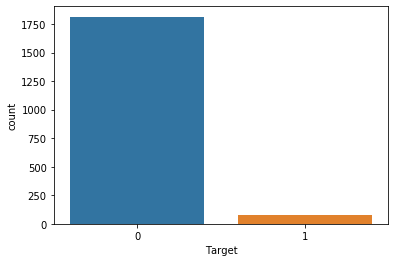

In [28]:
sns.countplot(x="Target", data= df_modeling);

We see that there is a high class imbalance in our dataset, I used SMOTE to synthetically bring up the profitable class to be equal to the non-profitable class.

In [19]:
target = df_modeling['Target']
features = df_modeling.drop(['Target'], axis=1)

In [20]:
X_train, X_test, y_train, y_test = train_test_split(features, target, random_state=25,test_size=0.30)

In [21]:
smote = SMOTE()
X_train_resampled, y_train_resampled = smote.fit_sample(X_train, y_train)
#X_train, y_train= X_train_resampled, y_train_resampled
# Preview synthetic sample class distribution
print('-----------------------------------------')
print('Synthetic sample class distribution: \n')
print(pd.Series(y_train_resampled).value_counts())

-----------------------------------------
Synthetic sample class distribution: 

1    1276
0    1276
Name: Target, dtype: int64


In [22]:
log = LogisticRegression()
log.fit(X_train_resampled, y_train_resampled)
log_preds = log.predict(X_test)

log_f1 = metrics.f1_score(y_test, log_preds)
log_acc = metrics.accuracy_score(y_test, log_preds)

print(classification_report(y_test, log_preds, target_names=['Dont Buy','Buy']))

              precision    recall  f1-score   support

    Dont Buy       0.96      0.88      0.92       538
         Buy       0.15      0.38      0.22        29

    accuracy                           0.86       567
   macro avg       0.56      0.63      0.57       567
weighted avg       0.92      0.86      0.89       567



/Users/avidanberman/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[[476  62]
 [ 18  11]]


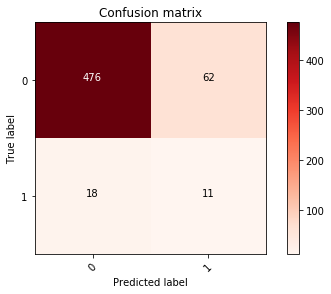

In [23]:
cm = confusion_matrix(y_test,log_preds)
classes = ['0','1']
plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Reds)

While judging our models we will be focusing on Accuracy and Precision. A high percision when predicting the profitable class is important due to loss of money. If we are predicting alot of cases that lose us money, then the model isn't maximizing our profits.

Based on the results I got from my baseline model, this model has an 86% Accuracy and a 15% Precision when predicting the profitable class. This model will almost definitely cause for us to lose money and isn't a good predictive model.

### K-Best Feature Selector:

In [25]:
scaler = StandardScaler()
# fit the scaler to the training data
scaler.fit(X_train_resampled)
#transform the training data

selector = SelectKBest(f_regression, k=22)

selector.fit(X_train_resampled, y_train_resampled)

selected_columns = X_train_resampled.columns[selector.get_support()]
removed_columns = X_train_resampled.columns[~selector.get_support()]

log_kbest = LogisticRegression()
log_kbest = log_kbest.fit(X_train_resampled[selected_columns], y_train_resampled)

log_kpreds = log_kbest.predict(X_test[selected_columns])

print(classification_report(y_test, log_kpreds, target_names=['Dont Buy','Buy']))

              precision    recall  f1-score   support

    Dont Buy       0.97      0.86      0.91       538
         Buy       0.15      0.48      0.23        29

    accuracy                           0.84       567
   macro avg       0.56      0.67      0.57       567
weighted avg       0.93      0.84      0.87       567



/Users/avidanberman/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/Users/avidanberman/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/Users/avidanberman/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/Users/avidanberman/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
/Users/avidanberman/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or s

[[446  94]
 [ 14  25]]


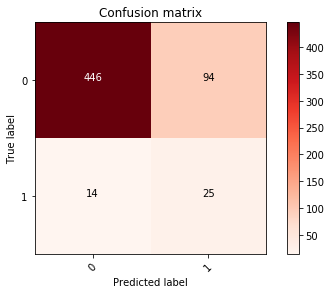

In [30]:
cm = confusion_matrix(y_test,log_kpreds)
classes = ['0','1']
plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Reds)

Using a K-Best Selector to pick our best columns we found that this is model actually did a worse job in terms of both precision and accuracy. It went too far towards the profitable side and gave us a poor precision score. Once again a model that will lose us money.

### Gridsearch on Logistic Regression

In [26]:
logreg = LogisticRegression()
parameters = {'C': [0.75,1.0,1.25,1.5],
             'max_iter': [100,200,300,400,500],
             'penalty': ['l1', 'l2']}
grid_tree1=GridSearchCV(logreg, parameters, cv=5, scoring='f1',verbose =1,n_jobs=-1)

grid_tree1.fit(X_train_resampled,y_train_resampled)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   17.7s finished
/Users/avidanberman/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [0.75, 1.0, 1.25, 1.5],
                         'max_iter': [100, 200, 300, 400, 500],
                         'penalty': ['l1', 'l2']},
             scoring='f1', verbose=1)

In [27]:
# Single best score achieved across all params (min_samples_split)
print(grid_tree1.best_score_)

# Dictionary containing the parameters (min_samples_split) used to generate that score
print(grid_tree1.best_params_)

# Actual model object fit with those best parameters
# Shows default parameters that we did not specify
print(grid_tree1.best_estimator_)

0.9449562813899165
{'C': 1.5, 'max_iter': 500, 'penalty': 'l2'}
LogisticRegression(C=1.5, max_iter=500)


In [28]:
#Predict the response for test dataset
y_pred = grid_tree1.best_estimator_.predict(X_test)

# Model Accuracy, how often is the classifier correct?
print(classification_report(y_test, y_pred, target_names=['Dont Buy','Buy']))

              precision    recall  f1-score   support

    Dont Buy       0.97      0.94      0.95       538
         Buy       0.26      0.38      0.31        29

    accuracy                           0.91       567
   macro avg       0.61      0.66      0.63       567
weighted avg       0.93      0.91      0.92       567



[[507  31]
 [ 18  11]]


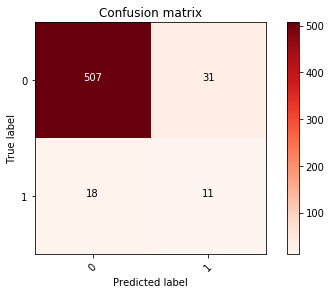

In [29]:
cm = confusion_matrix(y_test,y_pred)
classes = ['0','1']
plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Reds)

Our Gridsearch on Logistic Regression performed slightly better than our best Logistic Regression model in both accuracy and precision. Our Accuracy has gone up 6 points to 91% and our Precision has gone up from 15% to 26%. While this is an improvement, our model still isn't showing profitability if used in a business setting.

### KNN Model

In [34]:
knn = KNeighborsClassifier(n_neighbors=4)
knn.fit(X_train_resampled, y_train_resampled)

knn_preds = knn.predict(X_test)

knn_f1 = metrics.f1_score(y_test, knn_preds)

knn_acc = metrics.accuracy_score(y_test, knn_preds)

print(classification_report(y_test, knn_preds, target_names=['Dont Buy','Buy']))

              precision    recall  f1-score   support

    Dont Buy       0.97      0.88      0.92       538
         Buy       0.18      0.48      0.26        29

    accuracy                           0.86       567
   macro avg       0.57      0.68      0.59       567
weighted avg       0.93      0.86      0.89       567



[[474  64]
 [ 15  14]]


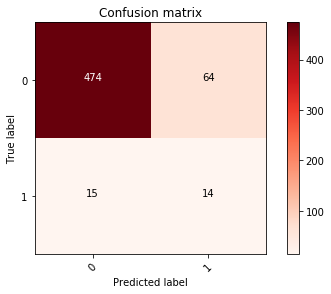

In [35]:
cm = confusion_matrix(y_test,knn_preds)
classes = ['0','1']
plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Reds)

Our KNN model performed significantly worse than our best model (Gridsearch Logistic Regression) in both Accuracy and Precision

### Decision Tree Model:

In [36]:
dtc = DecisionTreeClassifier(random_state = 25)

dtc.fit(X_train_resampled, y_train_resampled)

dtc_preds  = dtc.predict(X_test)

dtc_f1 = metrics.f1_score(y_test, dtc_preds)

dtc_acc = metrics.accuracy_score(y_test, dtc_preds)

print(classification_report(y_test, dtc_preds, target_names=['Dont Buy','Buy']))

              precision    recall  f1-score   support

    Dont Buy       0.96      0.98      0.97       538
         Buy       0.41      0.31      0.35        29

    accuracy                           0.94       567
   macro avg       0.69      0.64      0.66       567
weighted avg       0.93      0.94      0.94       567



[[525  13]
 [ 20   9]]


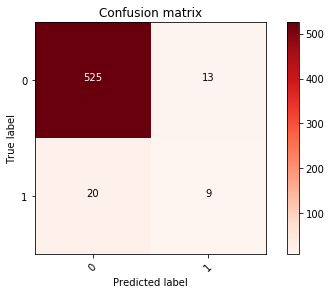

In [37]:
cm = confusion_matrix(y_test,dtc_preds)
classes = ['0','1']
plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Reds)

Compared to our previous results, this is quite a good showing for our baseline decision tree. It has a better Accuracy than my gridsearched logistic regression model and has increased in precision by 15%. This means that our model will be more profitable over time than the other models. As this is our best model, the precision is still not performing as well as required, and could still possibly be a non-profitable model in a business setting.

### Random Forest Models:

In [46]:
rfc = RandomForestClassifier(random_state = 25, n_estimators=20, max_features=6)
rfc.fit(X_train_resampled, y_train_resampled)
rfc_preds = rfc.predict(X_test)

rfc_f1 = metrics.f1_score(y_test, rfc_preds)
rfc_acc = metrics.accuracy_score(y_test, rfc_preds)

# checking accuracy on the test data
print(classification_report(y_test, rfc_preds, target_names=['Dont Buy','Buy']))

              precision    recall  f1-score   support

    Dont Buy       0.96      0.98      0.97       538
         Buy       0.38      0.28      0.32        29

    accuracy                           0.94       567
   macro avg       0.67      0.63      0.64       567
weighted avg       0.93      0.94      0.94       567



[[525  13]
 [ 21   8]]


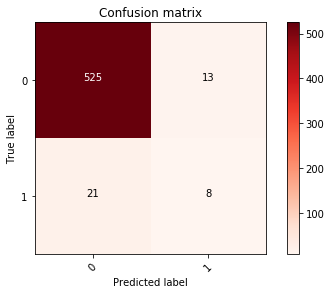

In [47]:
cm = confusion_matrix(y_test,rfc_preds)
classes = ['0','1']
plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Reds)

Our Random Forest model had a similar accuracy as our Decision Tree but had a slightly worse precision, can gridsearch help us find a better Random Forest model?

In [57]:
param_grid2 = { 
    'n_estimators': [50,100,150,200],
    'max_features': [4,5,6,7,8],
    'criterion' : ['gini','entropy']
    
}

rfc_CV = RandomForestClassifier(random_state = 25)
rfc_CV = GridSearchCV(estimator=rfc_CV, param_grid=param_grid2, cv= 10, scoring='f1', verbose=1, n_jobs=-1)
rfc_CV.fit(X_train_resampled, y_train_resampled)

Fitting 10 folds for each of 40 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   24.6s
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:   54.7s finished


GridSearchCV(cv=10, estimator=RandomForestClassifier(random_state=25),
             n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_features': [4, 5, 6, 7, 8],
                         'n_estimators': [50, 100, 150, 200]},
             scoring='f1', verbose=1)

In [58]:
# Identify the best params 
print(rfc_CV.best_params_)
print(rfc_CV.best_estimator_)


#Identify the best score during fitting with cross-validation
print(rfc_CV.best_score_)

#predict on the test set
test_preds_rfc_CV = rfc_CV.best_estimator_.predict(X_test)

# checking metrics
print(classification_report(y_test, test_preds_rfc_CV, target_names=['Dont Buy','Buy']))

{'criterion': 'entropy', 'max_features': 5, 'n_estimators': 100}
RandomForestClassifier(criterion='entropy', max_features=5, random_state=25)
0.9752302032748281
              precision    recall  f1-score   support

    Dont Buy       0.96      0.97      0.97       538
         Buy       0.36      0.31      0.33        29

    accuracy                           0.94       567
   macro avg       0.66      0.64      0.65       567
weighted avg       0.93      0.94      0.93       567



[[522  16]
 [ 20   9]]


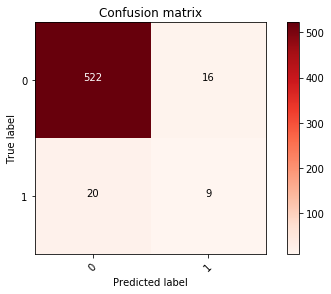

In [59]:
cm = confusion_matrix(y_test,test_preds_rfc_CV)
classes = ['0','1']
plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Reds)

My GridSearch wasn't able to help me find a better Random Forest Model, so our Decision Tree is still my best model.

### Voting Classifier

Using our different models, can a voting classifier put my models together to get better results?

In [71]:
voting_clf = VotingClassifier(
                estimators=[('knneighbors', knn), ('decisiontree', dtc), ('logreg', log), ('randomforest', rfc)], 
                voting='hard', weights= [1,1,1,1])

voting_clf.fit(X_train_resampled, y_train_resampled)

vc_preds = voting_clf.predict(X_test)

vc_f1 = metrics.f1_score(y_test, vc_preds)

vc_acc = metrics.accuracy_score(y_test, vc_preds)

print(classification_report(y_test, vc_preds, target_names=['Dont Buy','Buy']))

/Users/avidanberman/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


              precision    recall  f1-score   support

    Dont Buy       0.96      0.98      0.97       538
         Buy       0.44      0.28      0.34        29

    accuracy                           0.95       567
   macro avg       0.70      0.63      0.66       567
weighted avg       0.94      0.95      0.94       567



[[528  10]
 [ 21   8]]


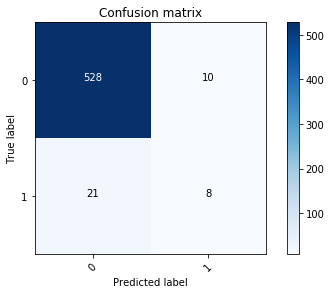

In [66]:
cm = confusion_matrix(y_test,vc_preds)
classes = ['0','1']
plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues)

Our Voting Classifier seems to be our best model so far. Based on manual testing, an evenly distributed voting classifier seems to be able to use the different models to cover the holes that other models missed. Our model still isn't great but this is the best so far. The Precision score was 44% (previous best was 41%) and an Accuracy score of 95%.

XG-Boost Classifier

In [22]:
labels = df_modeling['Target']
labels_removed_df = df_modeling.drop(columns='Target')

scaler = StandardScaler()
scaled_df = scaler.fit_transform(labels_removed_df)

X_train, X_test, y_train, y_test = train_test_split(scaled_df, labels)
smote = SMOTE()
X_train_resampled, y_train_resampled = smote.fit_sample(X_train, y_train)
X_train, y_train= X_train_resampled, y_train_resampled
 #Preview synthetic sample class distribution
print('-----------------------------------------')
print('Synthetic sample class distribution: \n')
print(pd.Series(y_train_resampled).value_counts())

-----------------------------------------
Synthetic sample class distribution: 

1    1357
0    1357
Name: Target, dtype: int64


In [25]:
param_grid = {
    "penalty": (["l1",'l2']),
    "max_depth":([2,3,4]),
    "C": ([0.001,.0001]),
    'learning_rate': [.1,.2,.3],
    "solver": (["newton-cg"]),
}

In [26]:
clf = xgb.XGBClassifier()
grid_clf = GridSearchCV(clf, param_grid, scoring='f1', cv=10, n_jobs=-1,verbose=1)
grid_clf.fit(scaled_df, labels)
best_parameters = grid_clf.best_params_
print("Grid Search found the following optimal parameters: ")
for param_name in sorted(best_parameters.keys()):
    print("%s: %r" % (param_name, best_parameters[param_name]))
training_preds = grid_clf.predict(X_train)
val_preds = grid_clf.predict(X_test)
print(classification_report(y_test, val_preds, target_names=['Dont Buy','Buy']))

Fitting 10 folds for each of 36 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   31.7s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:  5.6min finished


Grid Search found the following optimal parameters: 
C: 0.001
learning_rate: 0.2
max_depth: 4
penalty: 'l1'
solver: 'newton-cg'
              precision    recall  f1-score   support

    Dont Buy       0.98      1.00      0.99       457
         Buy       1.00      0.27      0.42        15

    accuracy                           0.98       472
   macro avg       0.99      0.63      0.70       472
weighted avg       0.98      0.98      0.97       472



[[457   0]
 [ 11   4]]


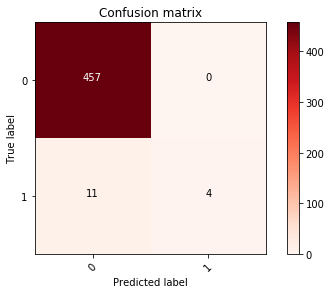

In [27]:
cm = confusion_matrix(y_test,val_preds)
classes = ['0','1']
plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Reds)

When comparing my XG-Boosted Model to my Voting Classifier I see that the XG-Boost Model is our best model. This is seen by  the significant increase in Percision of predicting the Profitable class (Went from 41% to 100%). This is a model we can trust when it tells us that a sneaker will be profitable.

I think it is important to note that our XG-Boost Model had a slightly worse recall rate (27%) than our Voting Classifier (28%). While I haven't spoken about this metric before, it is important to note that this model will not always predict the largest number of profitable shoes, rather it will be more profitable overall compared to the other models due to it's ability to limit False Positive cases which lose us money overall.

I view this model as a partial success. Over the course of time we should see that our model limit the number of times we lose money on a shoe while still letting us know that sneakers are profitable. In the future we should look to see if we can improve the recall while keeping precision at a high rate to improve the model's profitablility

In [29]:
with open('XG_Boost_model_3.pickle', 'wb') as handle:
    pickle.dump(grid_clf, handle, protocol=pickle.HIGHEST_PROTOCOL)